# Интерпретируем линейнные модели

In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_validate


import seaborn as sns

# Датасет: Wages

Игрушечный (по при этом настоящий) социологический датасет. 1985 год, Америка, 534 опрощенных

Features: 

    * EDUCATION: Number of years of education. 
    * SOUTH: Indicator variable for Southern Region (1=Person lives in South, 0=Person lives elsewhere). 
    * SEX: Indicator variable for sex (1=Female, 0=Male). 
    * EXPERIENCE: Number of years of work experience. 
    * UNION: Indicator variable for union membership (1=Union member, 0=Not union member). 
    * WAGE: Wage (dollars per hour). 
    * AGE: Age (years). 
    * RACE: Race (1=Other, 2=Hispanic, 3=White). 
    * OCCUPATION: Occupational category (1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other). 
    * SECTOR: Sector (0=Other, 1=Manufacturing, 2=Construction). 
    * MARR: Marital Status (0=Unmarried, 1=Married)


Скачаем его с [OpenML](https://www.openml.org/search?type=data&sort=runs&id=534&status=active)

In [3]:
# скачиваем данные
survey = fetch_openml(data_id=534, as_frame=True, parser="pandas")

In [4]:
X = survey.data[survey.feature_names]
X.head(3)

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried


In [7]:
# Посчитаем всякие статистики
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [8]:
# to numpy
y = survey.target.values.ravel()
survey.target.head(3)

# побьем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Посмотрим на совместные распределения

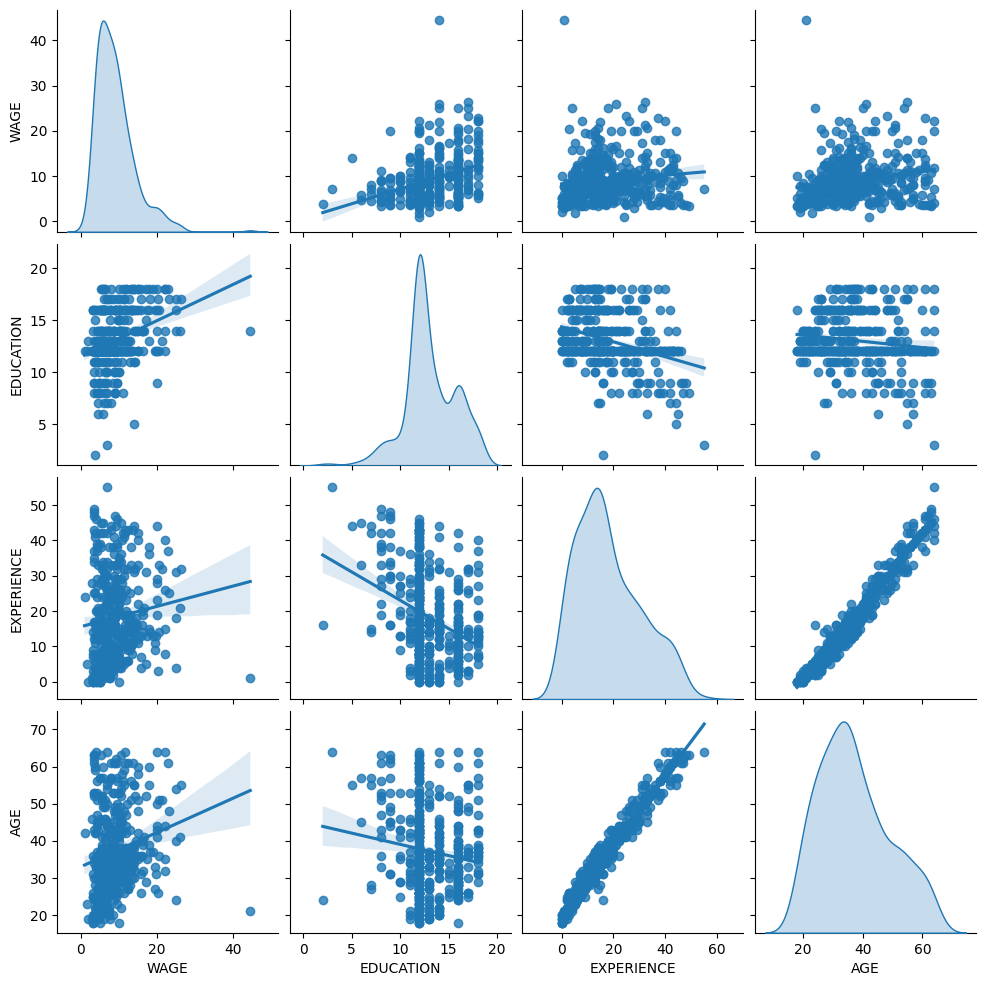

In [9]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(
    train_dataset,
    kind="reg",
    diag_kind="kde",
    # hue='SEX'
)

Как соотносятся между собой линейная регрессия, обученная на полных данных, и столбце WAGE этого графика? Может-ли отличаться знак коэффициента? 

## Распреление targetа

Какое-то распределение целевой переменной совсем не нормальное, с длинным хвостом. 

Как думаете, плохо ли это? А почему? 


(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  2., 18., 19., 25., 23.,
        32., 30., 34., 30., 43., 37., 30., 24., 15., 10., 12.,  7.,  5.,
         0.,  0.,  0.,  1.]),
 array([0.        , 0.12651631, 0.25303261, 0.37954892, 0.50606523,
        0.63258153, 0.75909784, 0.88561414, 1.01213045, 1.13864676,
        1.26516306, 1.39167937, 1.51819568, 1.64471198, 1.77122829,
        1.89774459, 2.0242609 , 2.15077721, 2.27729351, 2.40380982,
        2.53032613, 2.65684243, 2.78335874, 2.90987505, 3.03639135,
        3.16290766, 3.28942396, 3.41594027, 3.54245658, 3.66897288,
        3.79548919]),
 <BarContainer object of 30 artists>)

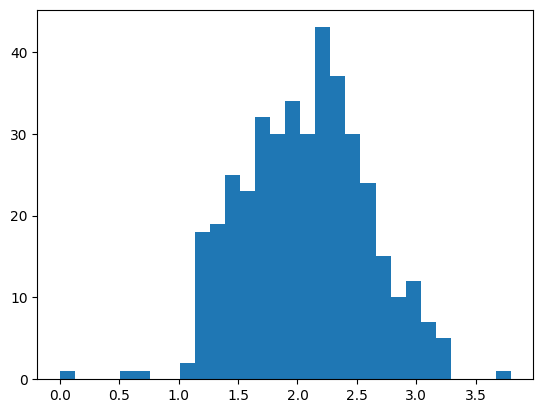

In [15]:
plt.hist(np.log(y_train), bins=30)

In [17]:
# А как численно оценить нормальность распределения и как ее исправить?
print(sp.stats.normaltest(np.log(y_train)))

y_train = np.log(y_train)
y_test = np.log(y_test)

# plt.hist(..., bins=30)

NormaltestResult(statistic=np.float64(0.4977241321902519), pvalue=np.float64(0.7796875113109835))


In [18]:
# типы данных
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


## Подготовка: 
    * OneHotEncoding для категориальных фичей (кроме бинарных, их выбросим)


In [22]:
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_columns), remainder="passthrough"
)

## Основной пайплайн

In [23]:
model = make_pipeline(preprocessor, Ridge(alpha=0.0001))

## Обучение


In [24]:
model.fit(X_train, y_train)

/home/arabella/Downloads/sync/work/teaching/teaching_venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])])),
                ('ridge', Ridge(alpha=0.0001))])

In [25]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

### А это что за график?

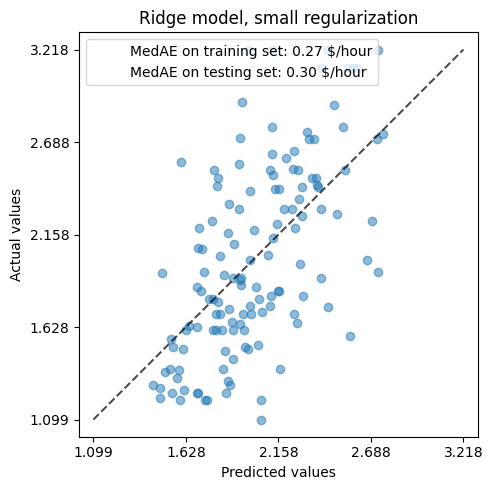

In [26]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

## Интерпретация, предостережение 0
Все выводы, которые мы делаем, мы делаем о нашей модели. Все выводы о реальном мире должны делаться поправкой на качество предсказаний.
Бывают данные, в которых зависимость не может быть линейной. Пример?

## Интерпретация, предостережение 1
Единицы измерений

In [27]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
onehotencoder__RACE_Other,0.010231
onehotencoder__RACE_White,0.083153
onehotencoder__OCCUPATION_Management,0.208343
onehotencoder__OCCUPATION_Other,-0.057902
onehotencoder__OCCUPATION_Professional,0.165598
onehotencoder__OCCUPATION_Sales,-0.107487
onehotencoder__OCCUPATION_Service,-0.209761
onehotencoder__SECTOR_Manufacturing,0.072422
onehotencoder__SECTOR_Other,-0.070983
onehotencoder__MARR_Unmarried,-0.074614


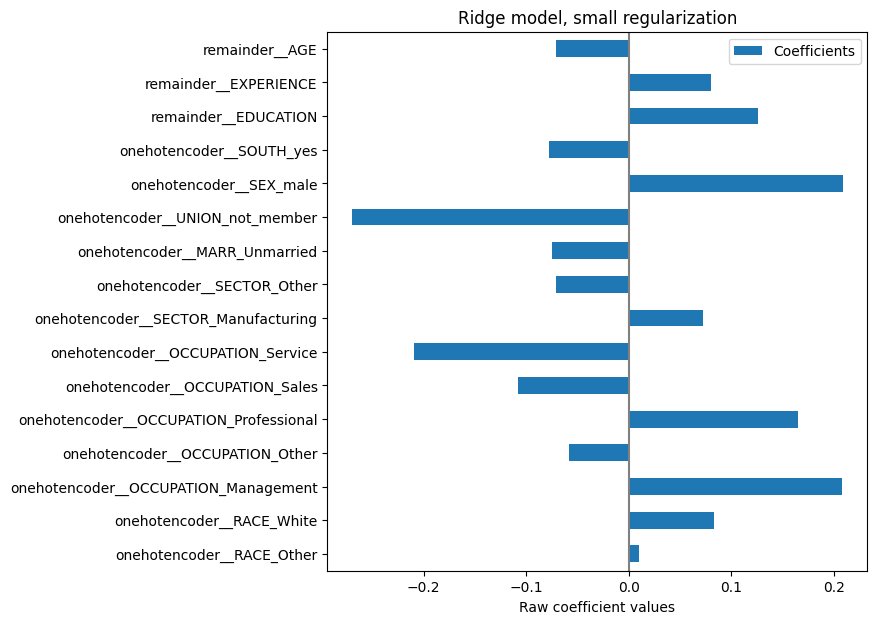

In [28]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

### Среднеквадратические отклонения в фичах

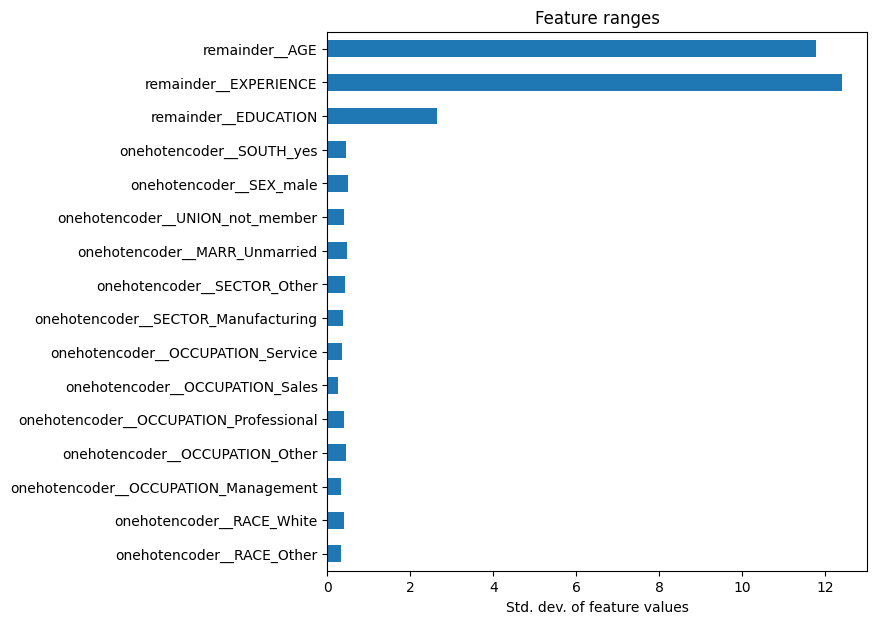

In [29]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

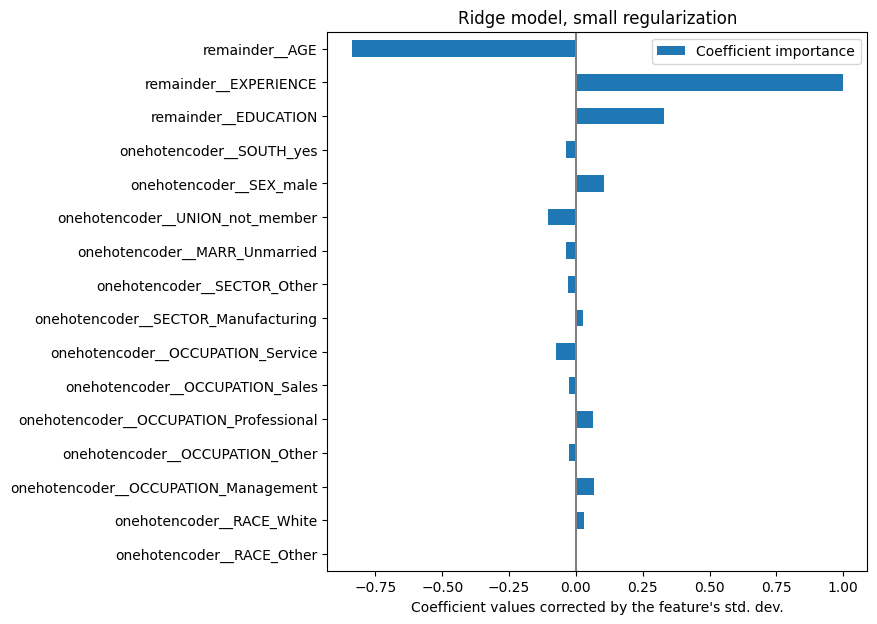

In [30]:
coefs = pd.DataFrame(
    model[-1].coef_
    * X_train_preprocessed.std(axis=0),  # перевзвесим коэффициенты на std
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# Интерпретация, предостережние 2

Что-нибудь вас здесь насторожило? AGE, например?

А насколько мы вообще уверены в наших коэффициентах? Как это можно оценить?

In [31]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

# Ящики с усами
![](https://upload.wikimedia.org/wikipedia/commons/3/32/Densityvsbox.png)

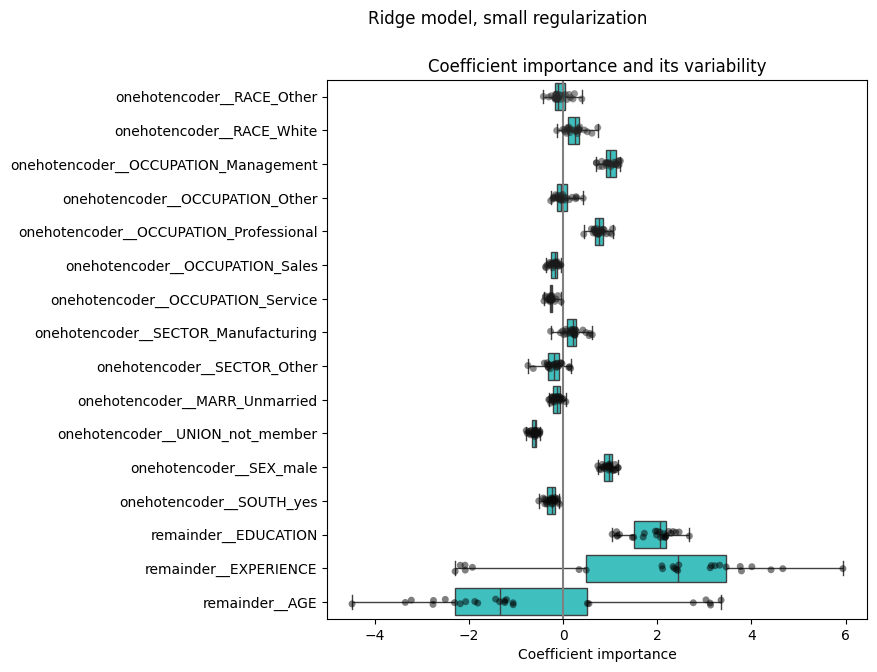

In [32]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

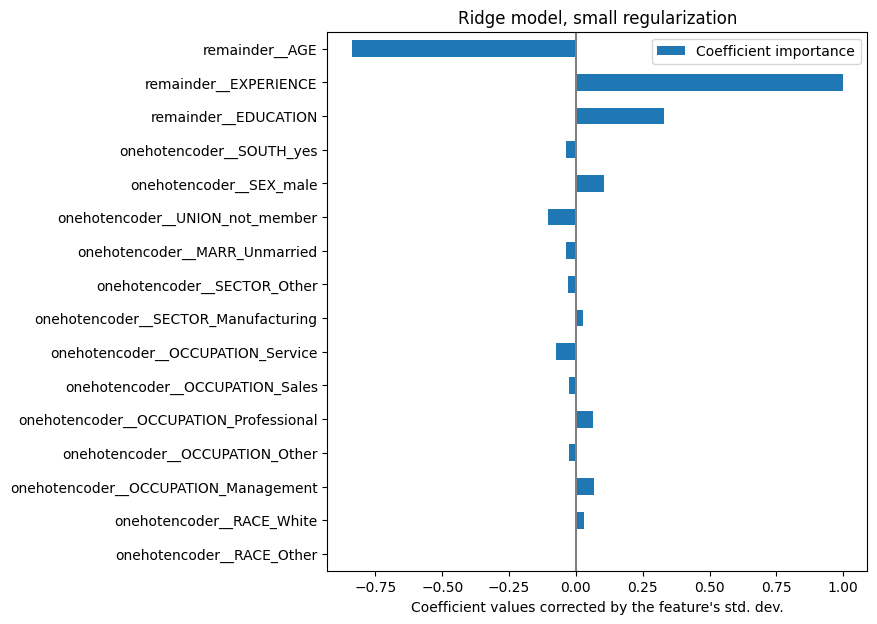

In [33]:
coefs = pd.DataFrame(
    model[-1].coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# Интерпретация, предостережение 3

Скоррелированные переменные это зло!

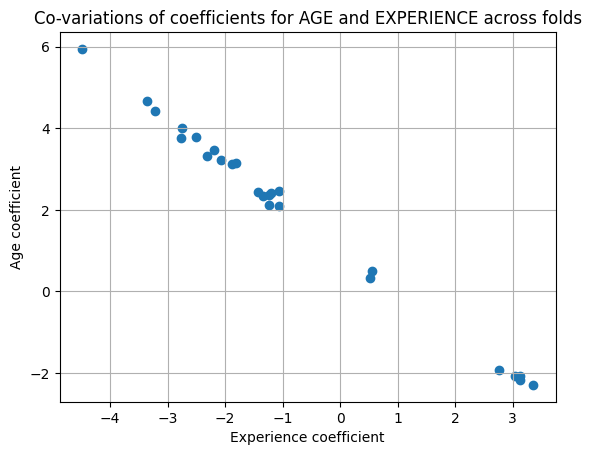

In [37]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.scatter(coefs["remainder__AGE"], coefs["remainder__EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

In [40]:
X

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...
529,18,no,male,5,not_member,29,White,Professional,Other,Unmarried
530,12,no,female,33,not_member,51,Other,Professional,Other,Married
531,17,no,female,25,member,48,Other,Professional,Other,Married
532,12,yes,male,13,member,31,White,Professional,Other,Married


In [41]:
column_to_drop = ["EXPERIENCE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)
coefs

,onehotencoder__RACE_Other,onehotencoder__RACE_White,onehotencoder__OCCUPATION_Management,onehotencoder__OCCUPATION_Other,onehotencoder__OCCUPATION_Professional,onehotencoder__OCCUPATION_Sales,onehotencoder__OCCUPATION_Service,onehotencoder__SECTOR_Manufacturing,onehotencoder__SECTOR_Other,onehotencoder__MARR_Unmarried,onehotencoder__UNION_not_member,onehotencoder__SEX_male,onehotencoder__SOUTH_yes,remainder__EDUCATION,remainder__EXPERIENCE
0,-0.045101,0.279709,1.005901,-0.046400,0.749087,-0.172129,-0.226272,0.188698,-0.147118,-0.073439,-0.598634,0.987092,-0.230203,1.448788,1.098259
1,-0.144781,0.337441,0.914268,-0.157472,0.662691,-0.371494,-0.377077,0.481663,-0.044322,-0.170316,-0.760026,1.164014,-0.169846,1.424612,1.025575
2,-0.173484,-0.001988,0.961117,-0.205067,1.053329,-0.134566,-0.277206,-0.266002,-0.746681,-0.198004,-0.601601,1.063695,-0.267589,1.427004,0.838661
3,0.045806,0.335261,0.903242,0.073999,0.601052,-0.210633,-0.252727,0.253724,-0.132002,-0.236460,-0.495058,0.831887,-0.292121,1.591275,1.040708
4,-0.082770,0.200680,1.217778,0.276756,0.856252,-0.082649,-0.153006,0.254910,-0.089484,-0.017438,-0.599679,0.764517,-0.343950,1.476491,1.069352
5,-0.085608,0.145936,1.172686,0.429601,0.719866,-0.045930,-0.040679,0.143815,-0.119735,0.008250,-0.493217,0.838458,-0.393118,1.670547,1.181007
6,-0.151260,0.045328,0.935864,-0.261870,0.815406,-0.295055,-0.284308,0.618773,0.124038,-0.240134,-0.670401,1.037910,-0.228503,1.577881,1.060991
7,-0.251718,0.324220,1.109971,-0.189773,0.676388,-0.361607,-0.247557,0.191136,-0.399171,-0.175820,-0.705680,1.085830,-0.159424,1.337233,0.803445
8,0.398950,0.736920,1.015534,-0.058358,0.838065,-0.106468,-0.369027,0.075614,-0.339629,-0.125595,-0.694251,0.850040,-0.227465,1.223221,0.856487
9,-0.112143,0.074840,0.768693,0.044145,0.792495,-0.167861,-0.300589,0.063294,-0.288658,-0.162647,-0.532431,0.985848,-0.265314,1.601829,1.156558


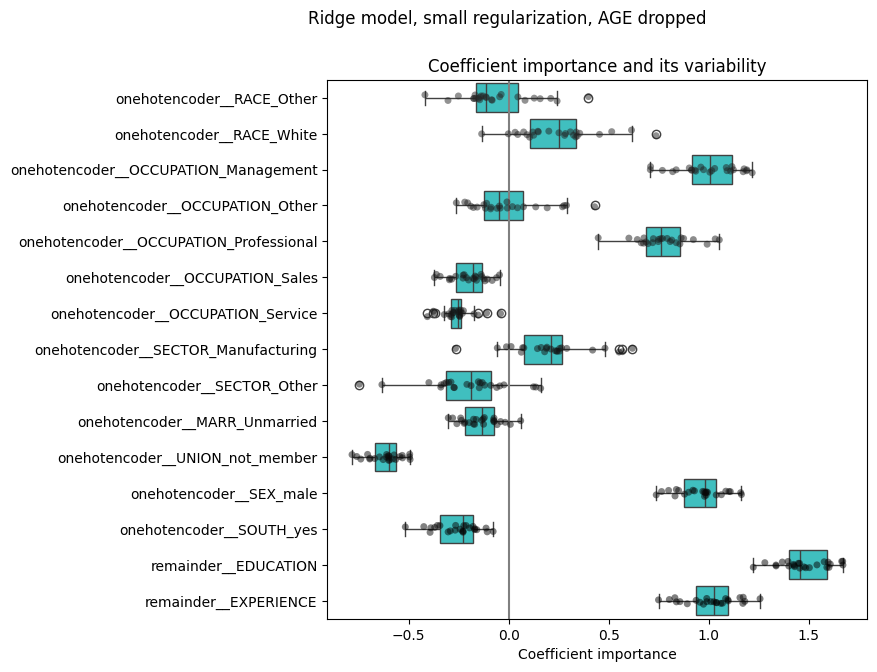

In [42]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.subplots_adjust(left=0.3)

## Регуляризация.

Что необходимо изменить в нашем пайпайне?

In [43]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_columns),
    (StandardScaler(), numerical_columns),
)


In [60]:
model = make_pipeline(preprocessor, Ridge(alpha=1e-10))
model.fit(X_train, y_train)
feature_names = model[:-1].get_feature_names_out()

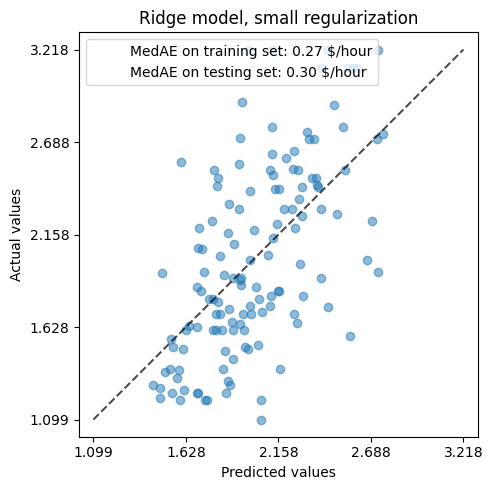

In [61]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [62]:
model[-1].coef_.shape, feature_names.shape

((16,), (16,))

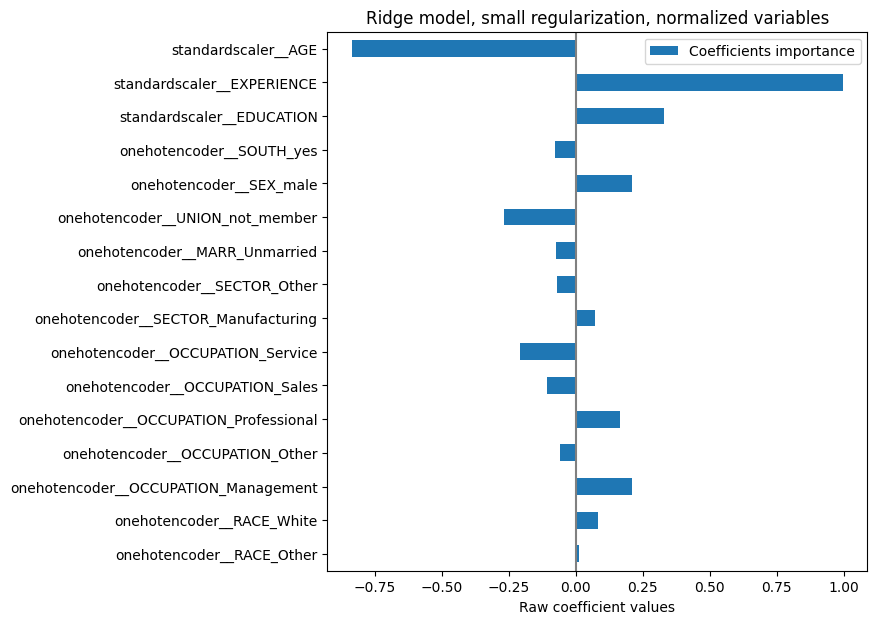

In [63]:
coefs = pd.DataFrame(
    model[-1].coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [64]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
)

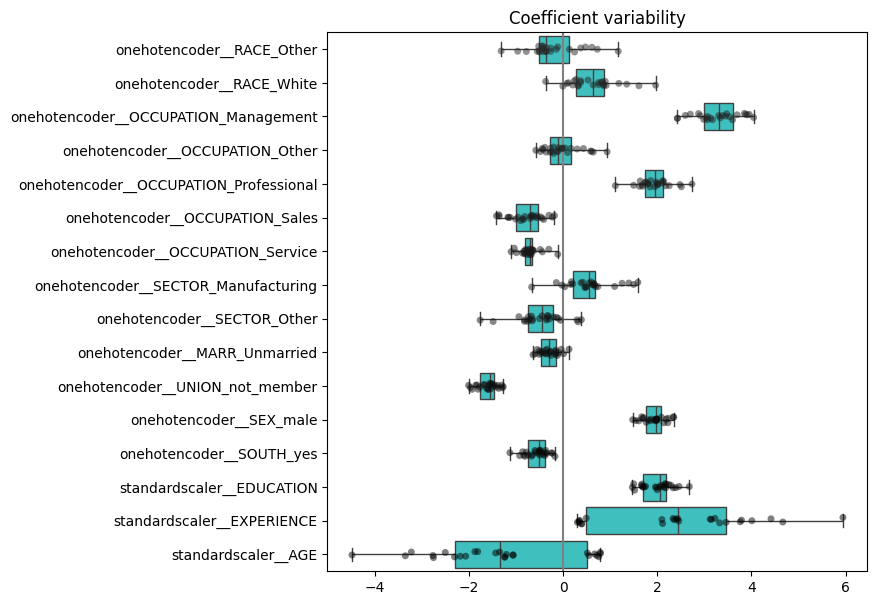

In [65]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## Регуляризация

Сначала попробуем обычную L2 регуляризацию. 

Как думаете, что произойдет с коэффициентами?

А что произойдет с их дисперсией?



In [66]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=alphas),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])))])

In [67]:
model[-1].alpha_

np.float64(10.0)

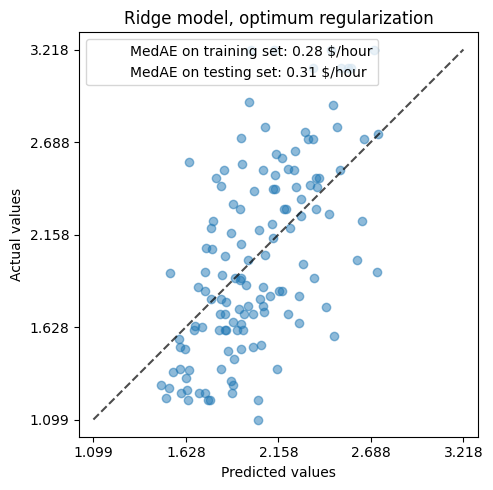

In [68]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

Кажется, качесво наших предсказаний почти не поменялось


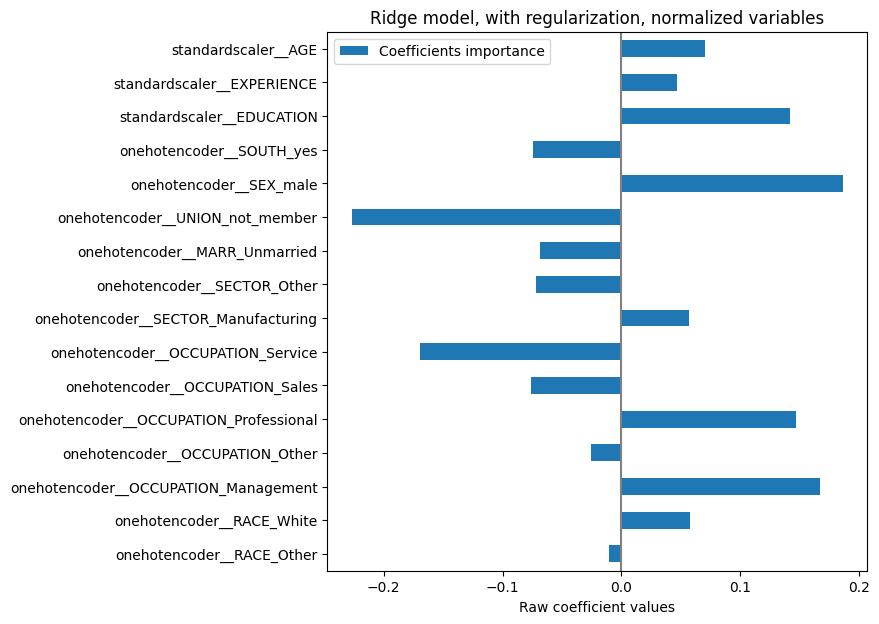

In [69]:
coefs = pd.DataFrame(
    model[-1].coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [70]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
)

In [71]:
# coefs.columns
feature_names

array(['onehotencoder__RACE_Other', 'onehotencoder__RACE_White',
       'onehotencoder__OCCUPATION_Management',
       'onehotencoder__OCCUPATION_Other',
       'onehotencoder__OCCUPATION_Professional',
       'onehotencoder__OCCUPATION_Sales',
       'onehotencoder__OCCUPATION_Service',
       'onehotencoder__SECTOR_Manufacturing',
       'onehotencoder__SECTOR_Other', 'onehotencoder__MARR_Unmarried',
       'onehotencoder__UNION_not_member', 'onehotencoder__SEX_male',
       'onehotencoder__SOUTH_yes', 'standardscaler__EDUCATION',
       'standardscaler__EXPERIENCE', 'standardscaler__AGE'], dtype=object)

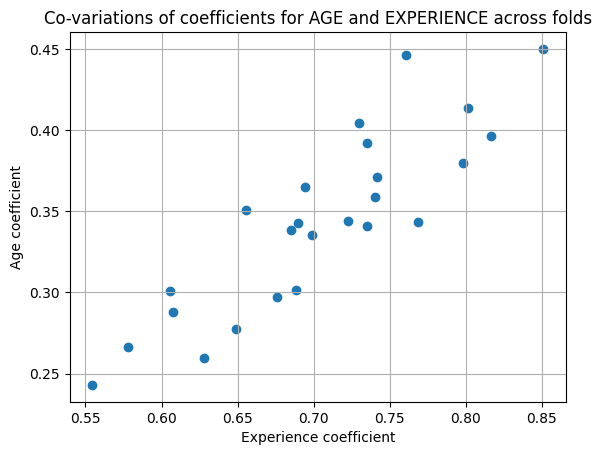

In [76]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.scatter(coefs["standardscaler__AGE"], coefs["standardscaler__EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

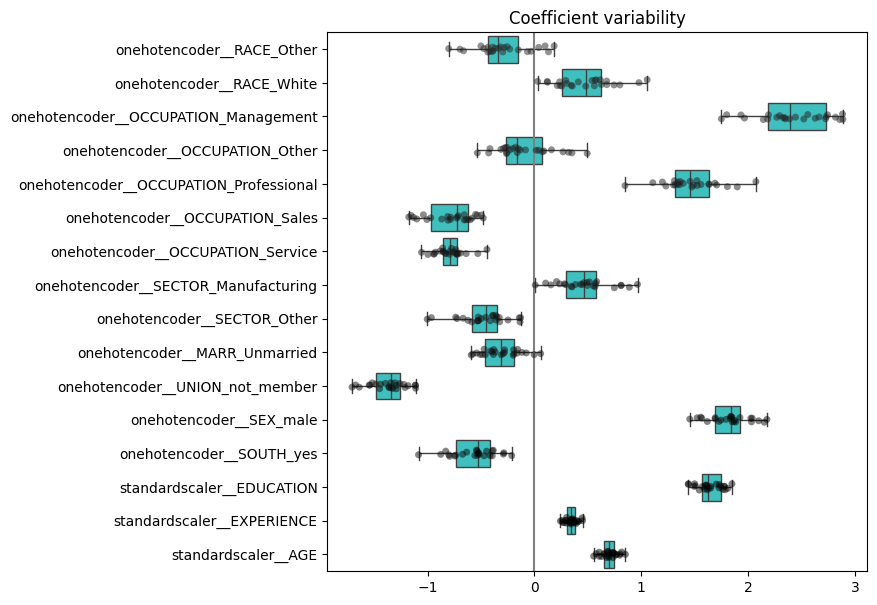

In [77]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## Linear models with sparse coefficients (Lasso)

Помните, зачем она нужна? А что произойдет с скореллированными переменными?

In [79]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-1, -1, 1)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    LassoCV(alphas=alphas, max_iter=100_000),
)

_ = model.fit(X_train, y_train)

In [80]:
model[-1].alpha_

np.float64(0.1)

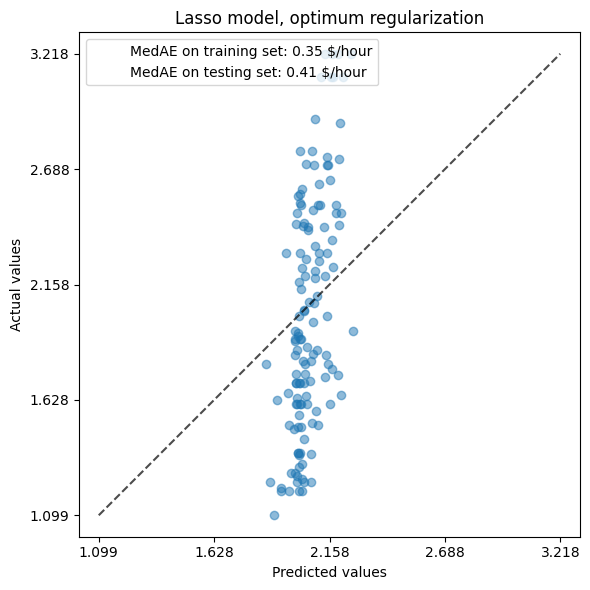

In [81]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

0.1


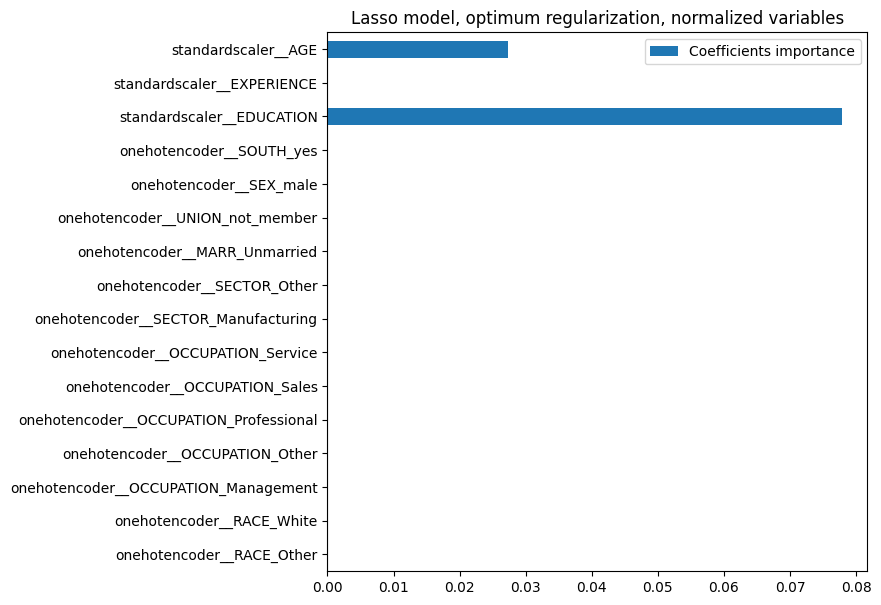

In [82]:
coefs = pd.DataFrame(
    model[-1].coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
print(model[-1].alpha_)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [83]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

# Интерапретация: проедупреждение 5
Корреляция не означает причинно-следственную связь. 

In [86]:
n_samples = 10_000
rng = np.random.RandomState(32)

experiences = rng.normal(20, 10, size=n_samples).astype(int)
experiences[experiences < 0] = 0
abilities = rng.normal(0, 0.15, size=n_samples)
parent_hourly_wages = 50 * rng.beta(2, 8, size=n_samples)
parent_hourly_wages[parent_hourly_wages < 0] = 0
college_degrees = (
    9 * abilities + 0.02 * parent_hourly_wages + rng.randn(n_samples) > 0.7
).astype(int)

true_coef = pd.Series(
    {
        "college degree": 2.0,
        "ability": 5.0,
        "experience": 0.2,
        "parent hourly wage": 1.0,
    }
)
hourly_wages = (
    true_coef["experience"] * experiences
    + true_coef["parent hourly wage"] * parent_hourly_wages
    + true_coef["college degree"] * college_degrees
    + true_coef["ability"] * abilities
    + rng.normal(0, 1, size=n_samples)
)

hourly_wages[hourly_wages < 0] = 0

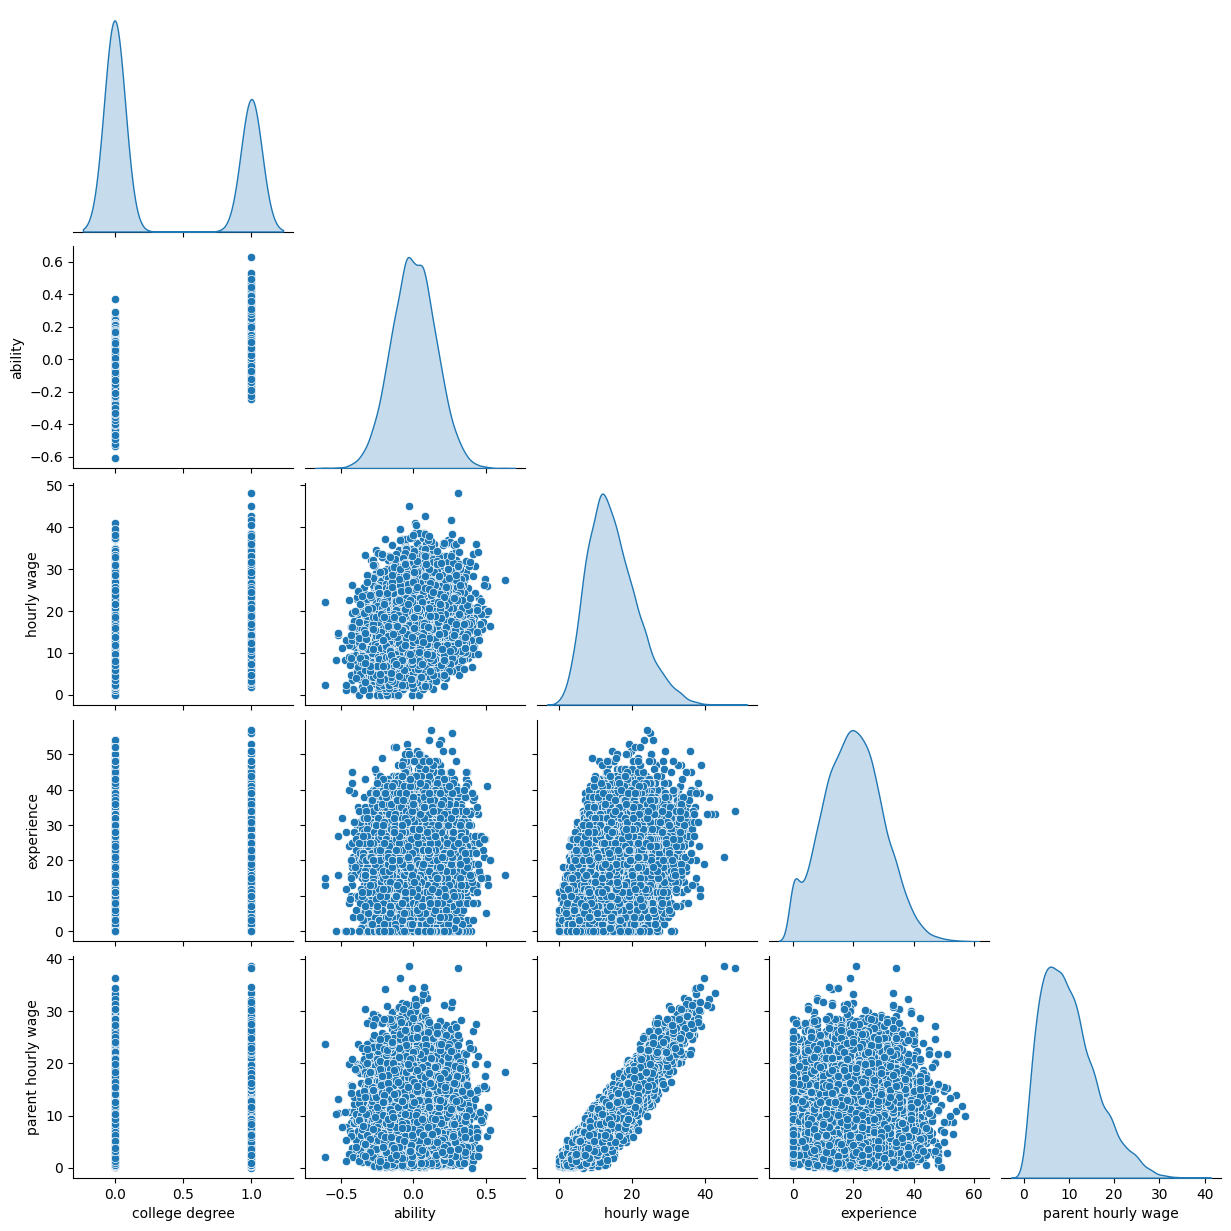

In [87]:
df = pd.DataFrame(
    {
        "college degree": college_degrees,
        "ability": abilities,
        "hourly wage": hourly_wages,
        "experience": experiences,
        "parent hourly wage": parent_hourly_wages,
    }
)

grid = sns.pairplot(df, diag_kind="kde", corner=True)

In [88]:
target_name = "hourly wage"
X, y = df.drop(columns=target_name), df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [89]:
from sklearn.metrics import r2_score

# кстати, кто такой R^2?

features_names = ["experience", "parent hourly wage", "college degree", "ability"]

regressor_with_ability = LinearRegression()
regressor_with_ability.fit(X_train[features_names], y_train)
y_pred_with_ability = regressor_with_ability.predict(X_test[features_names])
R2_with_ability = r2_score(y_test, y_pred_with_ability)

print(f"R2 score with ability: {R2_with_ability:.3f}")

R2 score with ability: 0.975


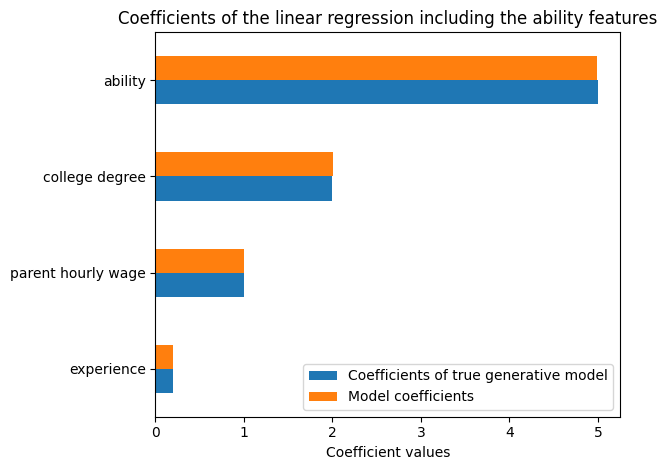

In [91]:
import matplotlib.pyplot as plt

model_coef = pd.Series(regressor_with_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
ax.set_title("Coefficients of the linear regression including the ability features")
_ = plt.tight_layout()

In [92]:
features_names = ["experience", "parent hourly wage", "college degree"]

regressor_without_ability = LinearRegression()
regressor_without_ability.fit(X_train[features_names], y_train)
y_pred_without_ability = regressor_without_ability.predict(X_test[features_names])
R2_without_ability = r2_score(y_test, y_pred_without_ability)

print(f"R2 score without ability: {R2_without_ability:.3f}")

R2 score without ability: 0.968


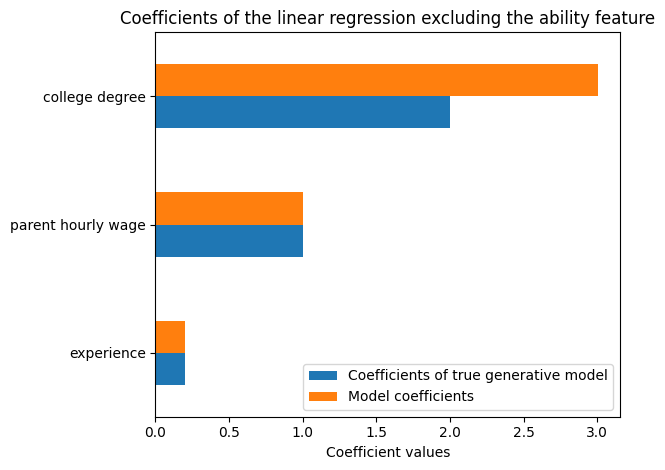

In [94]:
model_coef = pd.Series(regressor_without_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
_ = ax.set_title("Coefficients of the linear regression excluding the ability feature")
plt.tight_layout()
plt.show()

# Задача со звездочкой 10. Happiness.
Возьмите большой социологический датасет (например, World Value Survey) и узнайте, наконец, что делает людей счастливыми. Дизайн исследования на ваше усмотрение.

Оценка ставится, если вы присылаете читаемый и прокомментированный ноутбук, в котором отсутствуют ошибки дизайна исслледований, о которых мы говорили сегодня. Еще, мне будет гораздо приятнее проверять работы, в которых у вас получается выудить какой-то нетривиальный паттерн в этих данных, а не "инсоляция и доход повышают expexted happiness, a войны -- понижают". 

---

This notebook is heavily based on [this page](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html) at sklearn user guide.